# <FONT COLOR="red">***ADAPTIVE RANDOM FOREST - PROJECT DEVELOPMENT***</FONT>
---
---

The main objective behind the creation of this notebook is to check the feasibility of using the semi-supervised ML model called Adaptive Random Forest (ARF) for the classification of data flows within a telecommunications network.

You can see a sumary in the following video:

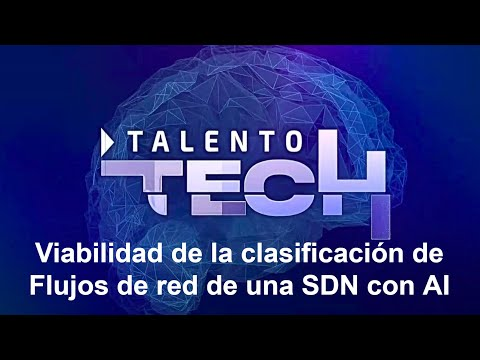

In [7]:
from IPython.display import YouTubeVideo

YouTubeVideo('wjKyDTbAtoU', width=1200, height=720, allowfullscreen=True)

## <FONT COLOR="orange">**Background**</FONT>
---
---
Different types of data and packets from different applications and services travel through telecommunications networks, which generally make up what is known as data flows.

Within telecommunications networks there is a classification of data flows according to their characteristics, which can be seen in the article [An Approach Based on Knowledge-Defined Networking for Identifying Heavy-Hitter Flows in Data Center Networks](https://www.mdpi.com/2076-3417/9/22/4808). In order to simplify the research, I decided to limit the identification of data flows only to elephant flows and their counterpart, mouse flows.

As a brief explanation on the subject:

*   **Elephant flows**: They are known for their large size, low frequency of occurrence and high bandwidth consumption.
*   **Mouse flows**: They are known for their small size, high frequency of occurrence within the network and low bandwidth consumption.

Mouse flows are usually susceptible to latency, so it is important to give them a prompt arrival at their destination so as not to affect the quality of the service provided. Likewise, elephant flows occupy a lot of bandwidth, so they are the main cause of excessive network traffic when they are in the network.

For this reason, this notebook presents the feasibility of using the semi-supervised ML algorithm called Adaptive Random Forest (ARF) for the classification of network flows.

## <FONT COLOR="orange">**LIBRARIES SELECTION AND INSTALLATION**</FONT>
---
---
To carry out the implementation of the ARF, it is necessary to first install the library in order to access its class [ARFClassifier](https://riverml.xyz/0.17.0/api/forest/ARFClassifier/) to be able to build and train the model with the flow records stored in the dataset.

Additionally, the `pandas` and `numpy` libraries were imported to manage the data stored in the dataset. The `ARFClassifier` and `evaluate` libraries from River allow for the creation of the model and its respective training and evaluation, since ARF models are semi-supervised. On the other hand, the `metrics` library allows for the import of evaluation metrics during model training, while the `stream` library, both from River, allows for the generation of data sets for training the ARF model.

The `OneHotEncoder` and `MinMaxScaler` libraries in `sklearn.preprocessing` allow data normalization to be performed so that the model is able to better extract information, context, and correlation between features and their labels. The `Pipeline` and `ColumnTransformer` libraries allow the implementation of libraries for normalization in a more efficient and data-safe way.

Finally, the `train_test_split` library allows the division of the data set, the `pickle` library allows saving the trained model and the `matplotlib.pyplot` and `seaborn` libraries facilitate the construction of graphs.


In [ ]:
# INSTALL RIVER LIBRARY
%%capture
!pip install river

In [ ]:
# IMPORT COMMON LIBRARIES
import numpy as np
import pandas as pd

# IMPORT ARF MODEL LIBRARY
from river.forest import ARFClassifier
from river import stream
from river import evaluate

# IMPORT METRICS LIBRARIES
from river import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc

# IMPORT UTILITY LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# IMPORT SAVE MODEL LIBRARY
import pickle

# IMPORT GRAPH LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns

## <FONT COLOR="orange">**KNOWING THE DATA**</FONT>
---
---
To train the ARF model, we must first know the data we will work with. It is important that you consult the notebook [Labeled_K-Means.ipynb](https://colab.research.google.com/drive/18luarQq2Qz5r3i-uhlPHrL1kIopNJTkV#scrollTo=YalplRtmbTgX) in which the details for generating the labels and the fields that the data set itself has are given.

It is important to note that the dataset includes the fields `start_time` and `end_time` that independently do not provide information to the model, therefore, to facilitate the extraction of the relationships between the features and the dataset, a new field called `duration` is created that indicates the duration of the flow in nanoseconds, while at the same time the fields `start_time` and `end_time` are eliminated because they provide redundant information.

In [ ]:
# DATASET
id = '1RwiV3X2aOQCF6uB9JVCoA7oUI1P8es-U'
url = f'https://drive.google.com/uc?id={id}'

In [ ]:
# DOWNLOAD AND LOAD DATASET
df_original = pd.read_csv(url)

# DISPLAY DATAFRAME
pd.set_option('display.max_columns', None)
display(df_original)

,start_time,end_time,ip_src,ip_dst,ip_proto,port_src,port_dst,size_pkt1,size_pkt2,size_pkt3,size_pkt4,size_pkt5,size_pkt6,size_pkt7,iat_pkt2,iat_pkt3,iat_pkt4,iat_pkt5,iat_pkt6,iat_pkt7,tot_size,flow_type
0,1261067166249838,1261067166272053,411772655,2443160248,6,80,43521,66,64,275,1518,1518,1518,1518,616,6289,14258,22,20,58,10992,elephant
1,1261067170895775,1261067171122094,4117798176,41177194186,6,80,1587,66,64,1518,1518,1518,1012,1518,8299,207090,121,125,1971,410,22521,elephant
2,1261067173048827,1261067173202738,411772655,2443160248,6,80,43584,66,64,1518,1518,1518,1518,1518,727,151600,21,19,744,20,14904,elephant
3,1261067172050638,1261067172468947,411772615,68157168224,6,80,62277,82,70,1518,1518,1518,1518,1518,43584,243392,21,34,43685,33,56918,mice
4,1261067167710641,1261067173371333,411777571,4117798220,6,63038,7020,145,127,128,129,109,64,122,190021,6995,25380,33936,30297,439,10705,elephant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60792,1261067634371104,1261067634623861,41177247242,2443160239,6,6724,80,66,64,1318,1318,1318,1318,1318,759,1401,5,1355,147,12519,19437,elephant
60793,1261069010672338,1261069010677963,4117726193,2443160248,6,80,65077,66,64,64,293,1518,1518,1518,838,28,2392,127,21,408,12338,elephant
60794,1261070817700685,1261070818252401,4117726176,7719721048,6,80,37991,66,64,1518,1028,1518,219,1518,79042,314555,5,140,4,78884,12095,elephant
60795,1261070563933414,1261070564563240,4117726176,77197128223,6,80,26105,66,64,1518,1028,1518,1518,770,81682,384447,94,156,81528,5,12010,mice


In [ ]:
# CREATE A COPY OF THE ORIGINAL DATAFRAME
df = df_original.copy()

# CREATE THE DURATION COLUMN AND DROP START AND END TIME COLUMNS
df.insert(loc=0, column='duration', value=df['end_time'] - df['start_time'])
df.drop(columns=['start_time', 'end_time'], inplace=True)

# DISPLAY DATAFRAME
display(df)

,duration,ip_src,ip_dst,ip_proto,port_src,port_dst,size_pkt1,size_pkt2,size_pkt3,size_pkt4,size_pkt5,size_pkt6,size_pkt7,iat_pkt2,iat_pkt3,iat_pkt4,iat_pkt5,iat_pkt6,iat_pkt7,tot_size,flow_type
0,22215,411772655,2443160248,6,80,43521,66,64,275,1518,1518,1518,1518,616,6289,14258,22,20,58,10992,elephant
1,226319,4117798176,41177194186,6,80,1587,66,64,1518,1518,1518,1012,1518,8299,207090,121,125,1971,410,22521,elephant
2,153911,411772655,2443160248,6,80,43584,66,64,1518,1518,1518,1518,1518,727,151600,21,19,744,20,14904,elephant
3,418309,411772615,68157168224,6,80,62277,82,70,1518,1518,1518,1518,1518,43584,243392,21,34,43685,33,56918,mice
4,5660692,411777571,4117798220,6,63038,7020,145,127,128,129,109,64,122,190021,6995,25380,33936,30297,439,10705,elephant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60792,252757,41177247242,2443160239,6,6724,80,66,64,1318,1318,1318,1318,1318,759,1401,5,1355,147,12519,19437,elephant
60793,5625,4117726193,2443160248,6,80,65077,66,64,64,293,1518,1518,1518,838,28,2392,127,21,408,12338,elephant
60794,551716,4117726176,7719721048,6,80,37991,66,64,1518,1028,1518,219,1518,79042,314555,5,140,4,78884,12095,elephant
60795,629826,4117726176,77197128223,6,80,26105,66,64,1518,1028,1518,1518,770,81682,384447,94,156,81528,5,12010,mice


## <FONT COLOR="orange">**DATA NORMALIZATION**</FONT>
---
---
As mentioned, normalizing numeric fields and encoding categorical fields makes it easier for the model to extract relationships between features and labels.

To achieve this, it is essential to know which fields are numeric and which are categorical in order to separate them since each group has a different treatment.

Regarding numeric data types, a normalization is applied with `MinMaxScaler` to make the maximum value $1$ and the minimum value $0$. This type of normalization allows the model to better interpret correlations that at first glance might seem far away from the rest of the data.

On the other hand, categorical data need to be encoded (in this case in numbers: 0,1,2,...) since the ARF model is not capable of processing data that is not numeric.


In [ ]:
# IDENTIFY NUMERICAL AND CATEGORICAL FEATURES
numerical_features = df.select_dtypes(include=['int64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [ ]:
# CREATE THE NUMERICAL AND CATEGORICAL TRANSFORMERS
numerical_transformer = Pipeline(
  steps = [
    ('scaler', MinMaxScaler())
  ]
)
categorical_transformer = Pipeline(
  steps = [
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
  ]
)

In [ ]:
# CREATE THE COLUMN TRANSFORMER
preprocessor = ColumnTransformer(
  transformers = [
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ]
)

In [ ]:
# IMPLEMENT PIPELINE
pipeline = Pipeline(
  steps = [
    ('preprocessor', preprocessor)
  ]
)

In [ ]:
# ADJUST THE PIPELINE TO THE DATA
pipeline.fit(df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['duration', 'ip_src',
                                                   'ip_dst', 'ip_proto',
                                                   'port_src', 'port_dst',
                                                   'size_pkt1', 'size_pkt2',
                                                   'size_pkt3', 'size_pkt4',
                                                   'size_pkt5', 'size_pkt6',
                                                   'size_pkt7', 'iat_pkt2',
                                                   'iat_pkt3', 'iat_pkt4',
                                                   'iat_pkt5', 'iat_pkt6',
                                                   'iat_pkt7', 'tot_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['flow_type'])]))])

In [ ]:
# DATA TRANSFORMATION
transformed_data = pipeline.transform(df)

# DISPLAY TRANSFORMED DATA
display(transformed_data[10])

array([1.34422153e-03, 1.61948795e-02, 1.89613657e-01, 0.00000000e+00,
       8.86240354e-04, 4.40390780e-02, 3.73134328e-03, 0.00000000e+00,
       9.44979367e-01, 9.44979367e-01, 9.44979367e-01, 9.44979367e-01,
       9.44979367e-01, 1.86564399e-01, 9.61563299e-01, 2.18032269e-04,
       2.30289704e-04, 2.06432706e-01, 2.61365898e-04, 1.03008826e-04,
       0.00000000e+00, 1.00000000e+00])

In [ ]:
# OBTAIN THE COLUMN NAMES
num_features_name = pipeline.named_steps['preprocessor'].transformers_[0][2]
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
cat_features_name = cat_encoder.get_feature_names_out(categorical_features)
features_name = num_features_name + list(cat_features_name)

# CREATE THE DATAFRAME
df_transformed = pd.DataFrame(columns=features_name, data=transformed_data)

# DISPLAY DATAFRAME
display(df_transformed)

,duration,ip_src,ip_dst,ip_proto,port_src,port_dst,size_pkt1,size_pkt2,size_pkt3,size_pkt4,size_pkt5,size_pkt6,size_pkt7,iat_pkt2,iat_pkt3,iat_pkt4,iat_pkt5,iat_pkt6,iat_pkt7,tot_size,flow_type_elephant,flow_type_mice
0,0.000010,0.001615,0.009607,0.0,0.000886,0.664005,0.003731,0.000000,0.145117,1.000000,1.000000,1.000000,1.000000,0.001228,0.002515,0.028514,0.000038,0.000034,0.000111,0.000006,1.0,0.0
1,0.000107,0.016195,0.161969,0.0,0.000886,0.023889,0.003731,0.000000,1.000000,1.000000,1.000000,0.651994,1.000000,0.016618,0.082856,0.000236,0.000244,0.003939,0.000818,0.000070,1.0,0.0
2,0.000072,0.001615,0.009607,0.0,0.000886,0.664967,0.003731,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001450,0.060654,0.000036,0.000032,0.001483,0.000034,0.000027,1.0,0.0
3,0.000198,0.001615,0.268096,0.0,0.000886,0.950313,0.033582,0.011257,1.000000,1.000000,1.000000,1.000000,1.000000,0.087300,0.097381,0.000036,0.000062,0.087439,0.000060,0.000261,0.0,1.0
4,0.002680,0.001615,0.016194,0.0,0.962885,0.106823,0.151119,0.118199,0.044017,0.044704,0.030949,0.000000,0.039890,0.380637,0.002798,0.050762,0.067951,0.060640,0.000877,0.000004,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60792,0.000119,0.161987,0.009607,0.0,0.102407,0.000885,0.003731,0.000000,0.862448,0.862448,0.862448,0.862448,0.862448,0.001514,0.000559,0.000004,0.002707,0.000288,0.025164,0.000052,1.0,0.0
60793,0.000002,0.016195,0.009607,0.0,0.000886,0.993054,0.003731,0.000000,0.000000,0.157497,1.000000,1.000000,1.000000,0.001673,0.000010,0.004779,0.000248,0.000036,0.000814,0.000013,1.0,0.0
60794,0.000261,0.016195,0.030362,0.0,0.000886,0.579591,0.003731,0.000000,1.000000,0.662999,1.000000,0.106602,1.000000,0.158328,0.125853,0.000004,0.000274,0.000002,0.158591,0.000012,1.0,0.0
60795,0.000298,0.016195,0.303655,0.0,0.000886,0.398153,0.003731,0.000000,1.000000,0.662999,1.000000,1.000000,0.485557,0.163616,0.153817,0.000182,0.000306,0.163190,0.000004,0.000011,0.0,1.0


In [ ]:
# JOIN THE LAST TWO COLUMNS
df_transformed['flow_type'] = df_transformed['flow_type_elephant']

# DROP THE LAST TWO COLUMNS
df_transformed.drop(columns=['flow_type_elephant', 'flow_type_mice'], inplace=True)

# DISPLAY DATAFRAME
display(df_transformed)

,duration,ip_src,ip_dst,ip_proto,port_src,port_dst,size_pkt1,size_pkt2,size_pkt3,size_pkt4,size_pkt5,size_pkt6,size_pkt7,iat_pkt2,iat_pkt3,iat_pkt4,iat_pkt5,iat_pkt6,iat_pkt7,tot_size,flow_type
0,0.000010,0.001615,0.009607,0.0,0.000886,0.664005,0.003731,0.000000,0.145117,1.000000,1.000000,1.000000,1.000000,0.001228,0.002515,0.028514,0.000038,0.000034,0.000111,0.000006,1.0
1,0.000107,0.016195,0.161969,0.0,0.000886,0.023889,0.003731,0.000000,1.000000,1.000000,1.000000,0.651994,1.000000,0.016618,0.082856,0.000236,0.000244,0.003939,0.000818,0.000070,1.0
2,0.000072,0.001615,0.009607,0.0,0.000886,0.664967,0.003731,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001450,0.060654,0.000036,0.000032,0.001483,0.000034,0.000027,1.0
3,0.000198,0.001615,0.268096,0.0,0.000886,0.950313,0.033582,0.011257,1.000000,1.000000,1.000000,1.000000,1.000000,0.087300,0.097381,0.000036,0.000062,0.087439,0.000060,0.000261,0.0
4,0.002680,0.001615,0.016194,0.0,0.962885,0.106823,0.151119,0.118199,0.044017,0.044704,0.030949,0.000000,0.039890,0.380637,0.002798,0.050762,0.067951,0.060640,0.000877,0.000004,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60792,0.000119,0.161987,0.009607,0.0,0.102407,0.000885,0.003731,0.000000,0.862448,0.862448,0.862448,0.862448,0.862448,0.001514,0.000559,0.000004,0.002707,0.000288,0.025164,0.000052,1.0
60793,0.000002,0.016195,0.009607,0.0,0.000886,0.993054,0.003731,0.000000,0.000000,0.157497,1.000000,1.000000,1.000000,0.001673,0.000010,0.004779,0.000248,0.000036,0.000814,0.000013,1.0
60794,0.000261,0.016195,0.030362,0.0,0.000886,0.579591,0.003731,0.000000,1.000000,0.662999,1.000000,0.106602,1.000000,0.158328,0.125853,0.000004,0.000274,0.000002,0.158591,0.000012,1.0
60795,0.000298,0.016195,0.303655,0.0,0.000886,0.398153,0.003731,0.000000,1.000000,0.662999,1.000000,1.000000,0.485557,0.163616,0.153817,0.000182,0.000306,0.163190,0.000004,0.000011,0.0


## <FONT COLOR="orange">**DATA SPLITING**</FONT>
---
---
For this experiment, it is known that the label is `flow_type` due to the processing previously performed in the notebook [Labeled_K-Means.ipynb](https://colab.research.google.com/drive/18luarQq2Qz5r3i-uhlPHrL1kIopNJTkV#scrollTo=YalplRtmbTgX), on the other hand, the features were selected as the remaining fields by removing `flow_type`.

Seeking to be transparent and for the results to be repeatable, a seed is established that allows generating the same results in the separation of the data regardless of how many times the process is repeated.

Finally, taking into account that the ARF model is of the semi-supervised type, the data division into three sets was carried out:

*   **Training**: Corresponds to those from which the model will abstract the relationships between the features and their corresponding label.
*   **Test**: It is the data set that the model will use to verify if its learning is correct in an iterative manner.
*   **Evaluation**: A data set that the ARF model has never seen before, used mainly to evaluate the performance of the model by identifying overfitting and its accuracy capacity.

For the division of the data sets, the stratification of the classes was taken into account to ensure that all correspond to a significant sample and of equal proportion of each of the classes of the `flow_type` field.

In [ ]:
# IDENTIFY THE FEATURES AND THE TARGET
X = df_transformed.drop(columns=['flow_type'])
y = df_transformed['flow_type']

In [ ]:
# SPLIT X AND y INTO BASE AND EVALUATION DATA
seed = 42
X_base, X_val, y_base, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# TEST THE STRATIFY SPLIT
print(f'Values of y_base: {y_base.value_counts(normalize=True)}')
print(f'Values of y_val: {y_val.value_counts(normalize=True)}')

# SPLIT X_base AND y_base INTO TRAIN AND TEST DATA
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.3, random_state=seed, stratify=y_base)

# TEST THE STRATIFY SPLIT
print(f'\n\nValues of y_train: {y_train.value_counts(normalize=True)}')
print(f'Values of y_test: {y_test.value_counts(normalize=True)}')

Values of y_base: flow_type
1.0    0.60308
0.0    0.39692
Name: proportion, dtype: float64
Values of y_val: flow_type
1.0    0.603125
0.0    0.396875
Name: proportion, dtype: float64


Values of y_train: flow_type
1.0    0.603084
0.0    0.396916
Name: proportion, dtype: float64
Values of y_test: flow_type
1.0    0.60307
0.0    0.39693
Name: proportion, dtype: float64


## <FONT COLOR="orange">**ARF MODEL**</FONT>
---
---
From the `river` library, the `ARFClassifier` class is implemented, which is an improvement of the already known Random Forest. The existence of $10$ instances (`n_models`) or trees is established as parameters, where the main division criterion is the information gain (`info_gain`) and the prediction criterion used by each leaf is decided by a Naive Bayes Adaptive (`nba`); seeking repeatability in the experiment, the same seed was used for the creation and training of the model.

Since the `arf` model performs incremental learning, it is necessary with the `stream` library to generate flows that contain both the training and test data.

The training in question of the `arf` model is done by prioritizing the F1 metric seeking to obtain the best relationship between precision and model fit.

In [ ]:
# CREATE MODEL
arf = ARFClassifier(
  n_models=10,
  split_criterion='info_gain',
  leaf_prediction='nba',
  seed=seed
)

In [ ]:
# CREATE A DATA STREAM
stream_data = stream.iter_pandas(X_train,y_train)

In [ ]:
# PROGRESIVE EVALUATION
metrics_arf = evaluate.progressive_val_score(
  dataset=stream_data,
  model=arf,
  metric=metrics.ClassificationReport(),
  print_every=10000
)

[10,000]            Precision   Recall   F1       Support  
                                                  
     0.0      99.95%   99.60%   99.77%      3984  
     1.0      99.73%   99.97%   99.85%      6015  
                                                  
   Macro      99.84%   99.78%   99.81%            
   Micro      99.82%   99.82%   99.82%            
Weighted      99.82%   99.82%   99.82%            

                 99.82% accuracy                  
[20,000]            Precision   Recall   F1       Support  
                                                  
     0.0      99.97%   99.80%   99.89%      8011  
     1.0      99.87%   99.98%   99.92%     11988  
                                                  
   Macro      99.92%   99.89%   99.91%            
   Micro      99.91%   99.91%   99.91%            
Weighted      99.91%   99.91%   99.91%            

                 99.91% accuracy                  
[30,000]            Precision   Recall   F1       Support  
  

## <FONT COLOR="orange">**SAVE MODEL**</FONT>
---
---
If at any time you want to avoid underlying problems when running tests in the same environment in which the training was done, then it is necessary to save and load the model, for which I commonly use the `pickle` library. Likewise, this practice allows you to save previous versions of the model to continue taking advantage of the benefits of semi-supervised learning.

In [ ]:
# SAVE THE MODEL
with open('arf_model.pkl','wb') as file:
  pickle.dump(arf, file)

In [ ]:
# LOAD A SAVED MODEL
with open('arf_model.pkl','rb') as file:
  arf_loaded_model = pickle.load(file)

## <FONT COLOR="orange">**MODEL EVALUATION**</FONT>
---
---
To carry out the evaluation of the results, the loaded model and the evaluation data set that the ARF model had never seen before are used.

The first test is seen through the confusion matrix where its great learning capacity is evident since it only failed in $1$ record out of $12160$; this high level of precision is matched by the ROC curve and its AUC area which are practically ideal. It is important to note that although at first glance the ROC curve suggests that the model is over-adjusted, this is not the case since the confusion matrix shows that the classifications made are almost perfect.

Finally, the values ​​of the evaluation metrics show that the model could be implemented in a telecommunications network and would offer surprising results.

In [ ]:
# CREATE PREDICTIONS
y_pred = [arf_loaded_model.predict_one(x) for x in X_val.to_dict('records')]

In [ ]:
## Construct the figure to the confusion matrix
def create_cm(conf, title):
  plt.imshow(conf, interpolation = "nearest")
  class_names = [0,1]
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # Create a heatmap in to the confusion matrix
  sns.heatmap(pd.DataFrame(conf), annot=True, cmap=plt.cm.Blues, fmt='g')
  plt.tight_layout()
  plt.title(title)
  plt.xlabel('Predict')
  plt.ylabel('Real')

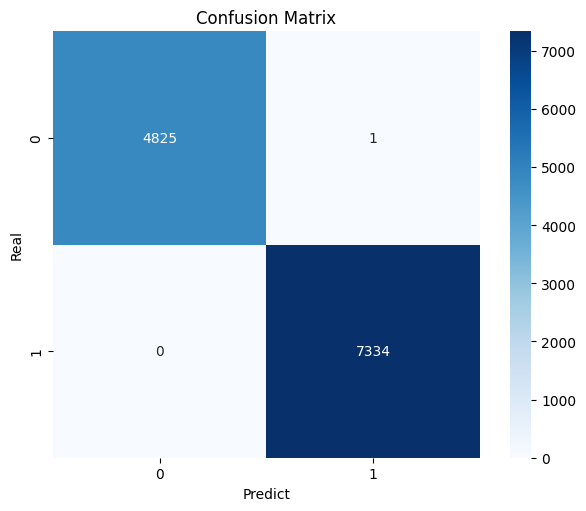

In [ ]:
matrix_arf=confusion_matrix(y_val, y_pred)
create_cm(matrix_arf, 'Confusion Matrix')

In [ ]:
# ROC FIGURE
def calculate_roc(test,predict):
  fpr, tpr, thresholds = roc_curve(test,predict)

  # Generate Figure
  fig = plt.figure(figsize=(5,5))
  plt.plot([0,1],[0,1],'k--')
  plt.plot(fpr,tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

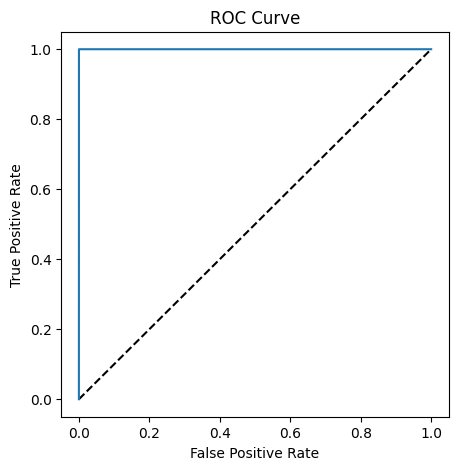

AUC of Adaptive Random Forest (ARF): 0.9998963945296311


In [ ]:
calculate_roc(y_val, y_pred)
auc_arf = roc_auc_score(y_val, y_pred)
print(f'AUC of Adaptive Random Forest (ARF): {auc_arf}')

In [ ]:
# CALCULATE METRICS
accuracy = accuracy_score(y_val,y_pred)
precision = precision_score(y_val,y_pred)
recall = recall_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred)

# DISPLAY METRICS
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.9999177631578947
Precision: 0.9998636673483299
Recall: 1.0
F1-Score: 0.9999318290272002


## <FONT COLOR="orange">**Conclusion**</FONT>
---
---
1.   The results presented in the evaluation of the model make it feasible to initially implement it on the server side in software-defined networks (SDN).
2.   Resource consumption tests are necessary to identify the viability of an ARF model within the application plane of an SDN.
3.   The analysis presented in this notebook confirms the feasibility of using an ARF model for flow classification within a Software-Defined Data Center Network (SDDCN).



## <FONT COLOR="orange">**Reference**</FONT>
---
---
**Creation of the UNIV1**: The dataset called UNIV1 is created in the [Labeled_K-Means.ipynb](https://colab.research.google.com/drive/18luarQq2Qz5r3i-uhlPHrL1kIopNJTkV#scrollTo=YalplRtmbTgX) notebook.

**Adaptive Random Forest Classifier**: The Adaptive Random Forest Classifier (ARFClassifier) is presented in the [*river*](https://riverml.xyz/0.17.0/api/forest/ARFClassifier/) documentation.